In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyBigWig

In [2]:
# native_exon_inclusion_file = "Data/se_splice_data/HepG2_natively_included_cassette_exons"
# native_exon_exclusion_file = "Data/se_splice_data/HepG2_natively_excluded_cassette_exons"

native_exon_inclusion_file = "Data/se_splice_data/K562_natively_included_cassette_exons"
native_exon_exclusion_file = "Data/se_splice_data/K562_natively_excluded_cassette_exons"
native_exon_all_file = "Data/se_splice_data/K562_native_cassette_exons_all"
native_exon_constitutive_file = "Data/se_splice_data/K562_constitutive_exons"

CONST = 500

In [3]:
df_ex_inc = pd.read_csv(native_exon_inclusion_file, sep='\t')
df_ex_exc = pd.read_csv(native_exon_exclusion_file, sep='\t')
df_ex_con = pd.read_csv(native_exon_constitutive_file, sep='\t')
df_ex_all = pd.read_csv(native_exon_all_file, sep='\t')
print(df_ex_exc.head())

                                          annotation           low_exon  \
0  chr1|-|1653150-1654026|1654073-1654146|1653150...    1653034-1653150   
1  chr1|-|1688047-1688217|1688321-1688619|1688047...    1687941-1688047   
2  chr1|-|2121220-2124283|2124414-2125077|2121220...    2121151-2121220   
3  chr1|+|10165802-10166254|10166641-10177516|101...  10165573-10165802   
4  chr1|+|11805894-11806183|11806280-11807496|118...  11805859-11805894   

        skipped_exon            hi_exon       incl         excl  
0    1654026-1654073    1654146-1654270  2192,7868  17572,63166  
1    1688217-1688321    1688619-1688707   693,4821   5748,33635  
2    2124283-2124414    2125077-2125349   986,2600   8067,21547  
3  10166254-10166641  10177516-10177658   388,2672   3166,18937  
4  11806183-11806280  11807496-11807602  1152,3470   9400,25577  


## Compute PSI values for exons:

In [4]:
def compute_psi(row, exp_num, read_length=100):
    inc_exc_1 = row['incl'] # incl, excl labels seem to be inaccurate in the original files!
    inc_exc_2 = row['excl']
    inc_exc = [inc_exc_1, inc_exc_2]
    
    inc, exc = [int(num) for num in inc_exc[exp_num].split(',')]
    
    exon_start, exon_end = [int(num) for num in row['skipped_exon'].split('-')]
    exon_length = exon_end-exon_start+1
    
    # IR_norm = inc/(exon_length + read_length - 1.)
    IR_norm = inc/(read_length - 1.)
    ER_norm = exc/(read_length - 1.)
    
    psi = IR_norm/(IR_norm+ER_norm)
    return psi

In [5]:
def compute_length(row):
    exon_start, exon_end = [int(num) for num in row['skipped_exon'].split('-')]
    exon_length = exon_end-exon_start+1
    return exon_length

0.769019537205901
0.9769866729369965
0.9284718275865678


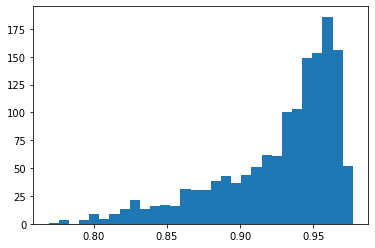

In [6]:
df_ex_inc['psi_1'] = df_ex_inc.apply(lambda row: compute_psi(row, 0), axis=1)
df_ex_inc['psi_2'] = df_ex_inc.apply(lambda row: compute_psi(row, 1), axis=1)
df_ex_inc['length'] = df_ex_inc.apply(lambda row: compute_length(row), axis=1)
df_ex_inc['avg'] = (df_ex_inc['psi_1'] + df_ex_inc['psi_2'])/2.
# print(df_ex_inc.head())

plt.hist(df_ex_inc['avg'], bins=30)
print(min(df_ex_inc['avg']))
print(max(df_ex_inc['avg']))
print(np.mean(df_ex_inc['psi_1']))
plt.savefig('including_psi_hist.png')

Empty DataFrame
Columns: [annotation, low_exon, skipped_exon, hi_exon, incl, excl, psi_1, psi_2, length, avg]
Index: []
too long 16
too short: 7
4
5081


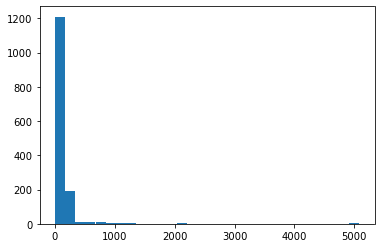

In [7]:
df_ex_inc_weird = df_ex_inc[df_ex_inc['avg'] < 0.5]
print(df_ex_inc_weird)

print('too long', len(df_ex_inc[df_ex_inc['length'] > 1000]))
print('too short:', len(df_ex_inc[df_ex_inc['length'] < 20]))
plt.hist(df_ex_inc['length'], bins=30)
print(min(df_ex_inc['length']))
print(max(df_ex_inc['length']))

0.09187691787054503
0.5114636096143341


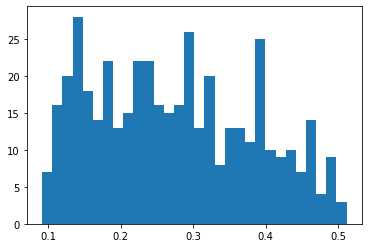

In [8]:
df_ex_exc['psi_1'] = df_ex_exc.apply(lambda row: compute_psi(row, 0), axis=1)
df_ex_exc['psi_2'] = df_ex_exc.apply(lambda row: compute_psi(row, 1), axis=1)
df_ex_exc['avg'] = (df_ex_exc['psi_1'] + df_ex_exc['psi_2'])/2.
# print(df_ex_exc.head())

plt.hist(df_ex_exc['avg'], bins=30)
print(min(df_ex_exc['avg']))
print(max(df_ex_exc['avg']))
plt.savefig('excluding_psi_hist.png')

0.09264094955489614
0.9768912987348309
0.7667172481628632
284
417


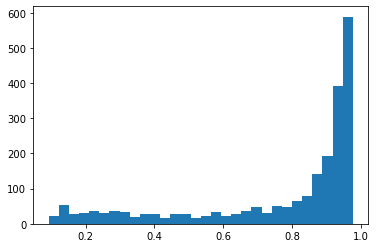

In [9]:
df_ex_all['psi_1'] = df_ex_all.apply(lambda row: compute_psi(row, 0), axis=1)
df_ex_all['psi_2'] = df_ex_all.apply(lambda row: compute_psi(row, 1), axis=1)
df_ex_all['length'] = df_ex_all.apply(lambda row: compute_length(row), axis=1)
df_ex_all['avg'] = (df_ex_all['psi_1'] + df_ex_all['psi_2'])/2.
# print(df_ex_inc.head())

plt.hist(df_ex_all['avg'], bins=30)
print(min(df_ex_all['psi_1']))
print(max(df_ex_all['psi_1']))
print(np.mean(df_ex_all['psi_1']))
# plt.savefig('all_psi_hist.png')

df_ex_all_filtered = df_ex_all[df_ex_all['avg'] >= 0.5114637]
df_ex_all_filtered = df_ex_all_filtered[df_ex_all_filtered['avg'] <= 0.7690195]
print(len(df_ex_all_filtered))

exc_inc_rbps_set = set(df_ex_exc['annotation']) | set(df_ex_inc['annotation'])
df_ex_all_filtered = df_ex_all[~ df_ex_all['annotation'].isin(exc_inc_rbps_set)]
print(len(df_ex_all_filtered))

In [41]:
meta_data_file = "Data/RBPs/bigwig_files_metadata_sample.csv"
meta_data = pd.read_csv(meta_data_file)
print(meta_data.head())
meta_hg19 = meta_data[(meta_data["assembly"]=='hg19') & (meta_data["cell_name"]=='K562') & (meta_data["rep_num"]==1)].reset_index(drop=True)
# print(meta_hg19.head())
print('total RBPs considered:', len(meta_hg19))

          stub    accession target  rep_num cell_name assembly strand
0  ENCFF411IAE  ENCFF411IAE    SSB        2      K562     hg19  minus
1  ENCFF131CHH  ENCFF131CHH    SSB        2      K562     hg19   plus
2  ENCFF805UMW  ENCFF805UMW    SSB        1      K562     hg19   plus
3  ENCFF623ASO  ENCFF623ASO    SSB        2      K562   GRCh38  minus
4  ENCFF732TUI  ENCFF732TUI    SSB        1      K562   GRCh38  minus
total RBPs considered: 239


In [42]:
#get known splicing RBPs from Megan's list
splicing_RBPs = pd.read_excel('Data/RBP_list_Gerstberger.xls', sheet_name='RBP table')
mask = splicing_RBPs.apply(lambda row: row.astype(str).str.contains('splicing').any(), axis=1)

splicing_RBPs = splicing_RBPs.loc[mask]
splicing_RBPs = set(splicing_RBPs['gene name'])
# print(splicing_RBPs)

print('before: ', len(meta_hg19))
meta_hg19 = meta_hg19[meta_hg19['target'].isin(splicing_RBPs)]
print('after: ', len(meta_hg19))

before:  239
after:  72


In [43]:
chr_list = ["chr" + str(i+1) for i in range(22)] + ["chrX", "chrY"]

rbp_dict = {}
len_list = []
len_dict = {}
avg_len_list = []
for idx, row in meta_hg19.iterrows():
    stub = row["stub"]
    target = row["target"]
    strand = row["strand"]
    bw_file = "Data/RBPs/bigwig_files/"+ stub +".bigWig"
    
    bw = pyBigWig.open(bw_file)
    
    # df_rbp = pd.read_csv(rbp_file, header=None, sep='\t')
    # df_rbp['len'] = df_rbp[2] - df_rbp[1] + 1
    # avg_len = np.mean(df_rbp['len'])
    # avg_len_list.append(avg_len)
    
    if target in rbp_dict:
        rbp_dict[target][strand] = bw
    else:
        rbp_dict[target] = {}
        rbp_dict[target][strand] = bw
        
    len_cur = 0
    for chro in chr_list:
        len_cur += len(bw.intervals("chr1"))
    len_dict[target] = len_cur
    len_list.append(len_cur)
    
    
meta_hg19['site_count'] = len_list
# meta_hg19['avg_len'] = avg_len_list
meta_hg19 = meta_hg19.sort_values(by='site_count', ascending=True)
print(meta_hg19.head())
# print('max_avg_len:', np.max(meta_hg19['avg_len']))
# print('min_avg_len:', np.min(meta_hg19['avg_len']))
# print('avg_len:', np.mean(meta_hg19['avg_len']))

            stub    accession  target  rep_num cell_name assembly strand  \
229  ENCFF522WHU  ENCFF522WHU   SF3B1        1      K562     hg19  minus   
230  ENCFF430PGG  ENCFF430PGG   SF3B1        1      K562     hg19   plus   
134  ENCFF733YZJ  ENCFF733YZJ   LARP7        1      K562     hg19   plus   
133  ENCFF058MZF  ENCFF058MZF   LARP7        1      K562     hg19  minus   
127  ENCFF722NAD  ENCFF722NAD  ZRANB2        1      K562     hg19  minus   

     site_count  
229      574560  
230      583416  
134      799392  
133      852864  
127      990384  


(array([6., 4., 4., 1., 7., 6., 2., 7., 5., 2., 2., 2., 0., 2., 0., 0., 1.,
        0., 1., 1., 5., 2., 2., 0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 1., 3.]),
 array([  574560. ,  1166492.4,  1758424.8,  2350357.2,  2942289.6,
         3534222. ,  4126154.4,  4718086.8,  5310019.2,  5901951.6,
         6493884. ,  7085816.4,  7677748.8,  8269681.2,  8861613.6,
         9453546. , 10045478.4, 10637410.8, 11229343.2, 11821275.6,
        12413208. , 13005140.4, 13597072.8, 14189005.2, 14780937.6,
        15372870. , 15964802.4, 16556734.8, 17148667.2, 17740599.6,
        18332532. , 18924464.4, 19516396.8, 20108329.2, 20700261.6,
        21292194. , 21884126.4, 22476058.8, 23067991.2, 23659923.6,
        24251856. ]),
 <BarContainer object of 40 artists>)

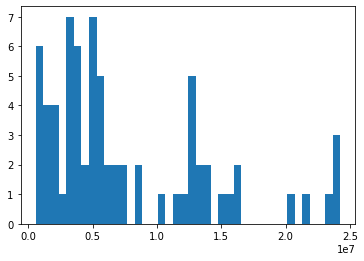

In [44]:
plt.hist(meta_hg19['site_count'], bins=40)

In [45]:
df_ex_inc['chr'] = df_ex_inc['annotation'].apply(lambda x: str(x).split("|")[0])
df_ex_inc['strand'] = df_ex_inc['annotation'].apply(lambda x: str(x).split("|")[1])
df_ex_inc['start'] = df_ex_inc['skipped_exon'].apply(lambda x: int(str(x).split("-")[0]))
df_ex_inc['end'] = df_ex_inc['skipped_exon'].apply(lambda x: int(str(x).split("-")[1]))
# print(df_ex_inc.head())
df_ex_inc_pos = df_ex_inc[df_ex_inc['strand'] == '+']
df_ex_inc_neg = df_ex_inc[df_ex_inc['strand'] == '-']

# inc_pos_tups = list(zip(df_ex_inc_pos['chr'], zip(df_ex_inc_pos['start'], df_ex_inc_pos['end'])))
# pos_end_tups = list(zip(df_ex_inc_pos['chr'], df_ex_inc_pos['end']))

# inc_neg_tups = list(zip(df_ex_inc_neg['chr'], zip(df_ex_inc_neg['start'], df_ex_inc_neg['end'])))
# neg_end_tups = list(zip(df_ex_inc_pos['chr'], df_ex_inc_neg['end']))
# print(inc_neg_tups[:10])

In [46]:
df_ex_exc['chr'] = df_ex_exc['annotation'].apply(lambda x: str(x).split("|")[0])
df_ex_exc['strand'] = df_ex_exc['annotation'].apply(lambda x: str(x).split("|")[1])
df_ex_exc['start'] = df_ex_exc['skipped_exon'].apply(lambda x: int(str(x).split("-")[0]))
df_ex_exc['end'] = df_ex_exc['skipped_exon'].apply(lambda x: int(str(x).split("-")[1]))
# print(df_ex_exc.head())
df_ex_exc_pos = df_ex_exc[df_ex_exc['strand'] == '+']
df_ex_exc_neg = df_ex_exc[df_ex_exc['strand'] == '-']

# exc_pos_tups = list(zip(df_ex_exc_pos['chr'], zip(df_ex_exc_pos['start'], df_ex_exc_pos['end'])))
# exc_neg_tups = list(zip(df_ex_exc_neg['chr'], zip(df_ex_exc_neg['start'], df_ex_exc_neg['end'])))
# print(exc_neg_tups[:10])

In [47]:
df_ex_con['chr'] = df_ex_con['annotation'].apply(lambda x: str(x).split("|")[0])
df_ex_con['strand'] = df_ex_con['annotation'].apply(lambda x: str(x).split("|")[1])
df_ex_con['start'] = df_ex_con['skipped_exon'].apply(lambda x: int(str(x).split("-")[0]))
df_ex_con['end'] = df_ex_con['skipped_exon'].apply(lambda x: int(str(x).split("-")[1]))
# print(df_ex_exc.head())
df_ex_con_pos = df_ex_con[df_ex_con['strand'] == '+']
df_ex_con_neg = df_ex_con[df_ex_con['strand'] == '-']

# con_pos_tups = list(zip(df_ex_con_pos['chr'], zip(df_ex_con_pos['start'], df_ex_con_pos['end'])))
# con_neg_tups = list(zip(df_ex_con_neg['chr'], zip(df_ex_con_neg['start'], df_ex_con_neg['end'])))
# print(exc_neg_tups[:10])

In [48]:
def tup_to_dict(tup_list):
    res_dict = {}
    for tup in tup_list:
        if tup[0] in res_dict:
            res_dict[tup[0]].append(tup[1])
        else:
            res_dict[tup[0]] = []
            res_dict[tup[0]].append(tup[1])
    return res_dict

# inc_pos_dict = tup_to_dict(inc_pos_tups)
# inc_neg_dict = tup_to_dict(inc_neg_tups)
# print(inc_neg_dict.keys())


# exc_pos_dict = tup_to_dict(exc_pos_tups)
# exc_neg_dict = tup_to_dict(exc_neg_tups)

# con_pos_dict = tup_to_dict(con_pos_tups)
# con_neg_dict = tup_to_dict(con_neg_tups)

In [49]:
count_overlapping_exons = 0
for chrom in exc_pos_dict:
    tups = inc_pos_dict[chrom]
    for tup1_idx in range(len(tups)-1):
        tup1 = tups[tup1_idx]
        for tup2_idx in range(tup1_idx+1, len(tups)):
            tup2 = tups[tup2_idx]
            if tup1[0] < tup2[0] and tup1[1] > tup2[0]:
                print(tup1, tup2)
                count_overlapping_exons += 1 
            elif tup2[0] < tup1[0] and tup2[1] > tup1[0]:
                print(tup1, tup2)
                count_overlapping_exons += 1 
print('number of overlapping exons: ', count_overlapping_exons)

NameError: name 'exc_pos_dict' is not defined

In [ ]:
def get_buckets(bw_rbp, df_exon, const=500):
    bucket_right = np.zeros(const, dtype=float)
    bucket_left = np.zeros(const, dtype=float)
    for idx, row in df_exon.iterrows():
        chromosom = row['chr']
        start = row['start']
        end = row['end']
        
        chr_len = bw_rbp.chroms()[chromosom]
        
        start_pos = max(start-const, 0)
        end_pos = min(end+const, chr_len-1)
        
        values_left = np.array(bw_rbp.stats(chromosom, start_pos, start, nBins=start-start_pos))
        values_left[values_left == None] = 0.
        values_left = values_left.astype(float, copy=False)
        
        values_right = np.array(bw_rbp.stats(chromosom, end, end_pos, nBins=end_pos-end))
        values_right[values_right == None] = 0.
        values_right = values_right.astype(float, copy=False)
        
        # print(values_left.dtype)
        # print(bucket_left.dtype)
        bucket_left += values_left
        bucket_right += values_right

    return bucket_right, bucket_left
            

# Processing an RBP:

In [ ]:
# df_rbp = rbp_dict['AQR']
# print(df_rbp.head())
df_rbp_pos = rbp_dict['AQR']['plus']
df_rbp_neg = rbp_dict['AQR']['minus']

In [ ]:
inc_pos_bucket_right, inc_pos_bucket_left = get_buckets(df_rbp_pos, df_ex_inc_pos)
inc_neg_bucket_left, inc_neg_bucket_right = get_buckets(df_rbp_neg, df_ex_inc_neg)

inc_bucket_right = inc_pos_bucket_right + inc_neg_bucket_right
inc_bucket_left = inc_pos_bucket_left + inc_neg_bucket_left

# inc_bucket_right = 100*inc_bucket_right/np.sum(inc_bucket_right)
# inc_bucket_left = 100*inc_bucket_left/np.sum(inc_bucket_left)

In [ ]:
inc_bucket_right = np.abs(inc_bucket_right)
inc_bucket_left = np.abs(inc_bucket_left)


y_limit = max(max(inc_bucket_left), max(inc_bucket_right)) + 10
y_min = min(min(inc_bucket_left), min(inc_bucket_right)) - 5

plt.tight_layout()
plt.figure(figsize=(15, 4))
ax_1 = plt.subplot(1, 2, 1)
print(len(inc_bucket_left))
ax_1.scatter([i for i in range(-CONST,0,1)], np.flip(inc_bucket_left))
ax_1.set_ylim([y_min, y_limit])

ax_2 = plt.subplot(1, 2, 2)
ax_2.scatter([i for i in range(1,CONST+1,1)], inc_bucket_right)
ax_2.set_ylim([y_min, y_limit])
plt.savefig('inc_buckets.jpg', dpi=400)

In [ ]:
exc_pos_bucket_right, exc_pos_bucket_left = get_buckets(df_rbp_pos, df_ex_exc_pos)
exc_neg_bucket_left, exc_neg_bucket_right = get_buckets(df_rbp_neg, df_ex_exc_neg)

exc_bucket_right = exc_pos_bucket_right + exc_neg_bucket_right
exc_bucket_left = exc_pos_bucket_left + exc_neg_bucket_left

# exc_bucket_right = 100*exc_bucket_right/np.sum(exc_bucket_right)
# exc_bucket_left = 100*exc_bucket_left/np.sum(exc_bucket_left)

In [ ]:
exc_bucket_right = np.abs(exc_bucket_right)
exc_bucket_left = np.abs(exc_bucket_left)

y_limit = max(max(exc_bucket_left), max(exc_bucket_right)) + 2
y_min = min(min(exc_bucket_left), min(exc_bucket_right)) - 5

plt.figure(figsize=(15, 4))
ax_1 = plt.subplot(1, 2, 1)
ax_1.scatter([i for i in range(-CONST,0,1)], np.flip(exc_bucket_left))
ax_1.set_ylim([y_min, y_limit])

ax_2 = plt.subplot(1, 2, 2)
ax_2.scatter([i for i in range(1,CONST+1,1)], exc_bucket_right)
ax_2.set_ylim([y_min, y_limit])

plt.savefig('exc_buckets.jpg', dpi=400)

# Processing all the RBPs:

total count: 72
max:  24251856
min:  574560
mean:  7620689.666666667
less than 10:  0
greater than 250:  72


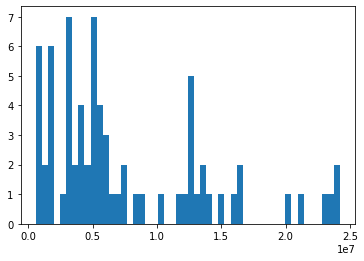

In [50]:
all_len_list = len_list
# for rbp_name in len_dict:
#     all_len_list += len_dict[rbp_name]
plt.hist(all_len_list, bins=50)
print('total count:', len(all_len_list))
print('max: ', np.max(all_len_list))
print('min: ', np.min(all_len_list))
print('mean: ', np.mean(all_len_list))
print('less than 10: ', np.sum(np.array(all_len_list) < 10))
print('greater than 250: ', np.sum(np.array(all_len_list) > 250))

In [51]:
def generate_data(rbps, df_exon, const=5000, strand='plus'):
    rows = []
    for rbp in rbps:
        bw_rbp_both = rbps[rbp]
        if strand not in bw_rbp_both:
            print(rbp, strand)
            continue
            
        bw_rbp = bw_rbp_both[strand]
        
        for exon_idx, row in df_exon.iterrows():
            chromosom = row['chr']
            start = row['start']
            end = row['end']
            chr_len = bw_rbp.chroms()[chromosom]

            start_pos = max(start-const, 0)
            end_pos = min(end+const, chr_len-1)
            
            intervals = bw_rbp.intervals(chromosom, start_pos, end_pos)
            if intervals is None:
                continue
        
            new_row = (exon_idx, chromosom, start, end, rbp, strand)
            rows.append(new_row)
                
    df = pd.DataFrame(rows, columns=['exon_idx', 'chr', 'exon_start', 'exon_end', 'rbp', 'strand'])
    return df

## Run this section only if you do not want to use precomputed tables:

In [52]:
excluding_pos_df = generate_data(rbp_dict, df_ex_exc_pos, const=5000, strand='plus')
excluding_neg_df = generate_data(rbp_dict, df_ex_exc_neg, const=5000, strand='minus')

In [53]:
# excluding_pos_df['strand'] = ['+' for i in range(len(excluding_pos_df))]
print(excluding_pos_df.head())
# excluding_neg_df['strand'] = ['-' for i in range(len(excluding_neg_df))]
print(excluding_neg_df.head())
excluding_df = pd.concat([excluding_pos_df, excluding_neg_df]).reset_index(drop=True)
print(excluding_df.head())
excluding_df.to_csv('excluding_df_bw_K562_filtered.csv')

   exon_idx   chr  exon_start  exon_end     rbp strand
0         3  chr1    10166254  10166641  GTF2F1   plus
1         4  chr1    11806183  11806280  GTF2F1   plus
2         8  chr1    22400586  22400712  GTF2F1   plus
3         9  chr1    26438950  26439141  GTF2F1   plus
4        11  chr1    28857034  28857085  GTF2F1   plus
   exon_idx   chr  exon_start  exon_end     rbp strand
0         0  chr1     1654026   1654073  GTF2F1  minus
1         1  chr1     1688217   1688321  GTF2F1  minus
2         2  chr1     2124283   2124414  GTF2F1  minus
3         5  chr1    19472516  19472600  GTF2F1  minus
4         6  chr1    21219111  21219222  GTF2F1  minus
   exon_idx   chr  exon_start  exon_end     rbp strand
0         3  chr1    10166254  10166641  GTF2F1   plus
1         4  chr1    11806183  11806280  GTF2F1   plus
2         8  chr1    22400586  22400712  GTF2F1   plus
3         9  chr1    26438950  26439141  GTF2F1   plus
4        11  chr1    28857034  28857085  GTF2F1   plus


In [54]:
including_pos_df = generate_data(rbp_dict, df_ex_inc_pos, const=5000, strand='plus')
including_neg_df = generate_data(rbp_dict, df_ex_inc_neg, const=5000, strand='minus')

In [55]:
print(including_pos_df.head())
print(including_neg_df.head())

including_df = pd.concat([including_pos_df, including_neg_df]).reset_index(drop=True)
print(including_df.head())
including_df.to_csv('including_df_bw_K562_filtered.csv')

   exon_idx   chr  exon_start  exon_end     rbp strand
0         6  chr1     6880240   6880310  GTF2F1   plus
1         8  chr1     9630315   9630416  GTF2F1   plus
2         9  chr1    12042026  12042171  GTF2F1   plus
3        10  chr1    12081701  12081897  GTF2F1   plus
4        11  chr1    15753645  15753780  GTF2F1   plus
   exon_idx   chr  exon_start  exon_end     rbp strand
0         0  chr1     1203241   1203372  GTF2F1  minus
1         1  chr1     1643702   1643839  GTF2F1  minus
2         2  chr1     1685489   1685647  GTF2F1  minus
3         3  chr1     1770628   1770677  GTF2F1  minus
4         4  chr1     3753058   3753256  GTF2F1  minus
   exon_idx   chr  exon_start  exon_end     rbp strand
0         6  chr1     6880240   6880310  GTF2F1   plus
1         8  chr1     9630315   9630416  GTF2F1   plus
2         9  chr1    12042026  12042171  GTF2F1   plus
3        10  chr1    12081701  12081897  GTF2F1   plus
4        11  chr1    15753645  15753780  GTF2F1   plus


In [56]:
constitutive_pos_df = generate_data(rbp_dict, df_ex_con_pos, const=5000, strand='plus')
constitutive_neg_df = generate_data(rbp_dict, df_ex_con_neg, const=5000, strand='minus')

In [57]:
print(constitutive_pos_df.head())
print(constitutive_neg_df.head())

constitutive_df = pd.concat([constitutive_pos_df, constitutive_neg_df]).reset_index(drop=True)
print(constitutive_df.head())
constitutive_df.to_csv('constitutive_df_bw_K562_filtered.csv')

   exon_idx   chr  exon_start  exon_end     rbp strand
0        10  chr1     1414428   1414488  GTF2F1   plus
1        11  chr1     1453095   1453155  GTF2F1   plus
2        12  chr1     1461840   1461911  GTF2F1   plus
3        23  chr1     2333645   2333781  GTF2F1   plus
4        32  chr1     6885151   6885270  GTF2F1   plus
   exon_idx   chr  exon_start  exon_end     rbp strand
0         0  chr1      880897    881033  GTF2F1  minus
1         1  chr1      887791    887980  GTF2F1  minus
2         2  chr1      892273    892405  GTF2F1  minus
3         3  chr1     1153837   1154013  GTF2F1  minus
4         4  chr1     1159211   1159348  GTF2F1  minus
   exon_idx   chr  exon_start  exon_end     rbp strand
0        10  chr1     1414428   1414488  GTF2F1   plus
1        11  chr1     1453095   1453155  GTF2F1   plus
2        12  chr1     1461840   1461911  GTF2F1   plus
3        23  chr1     2333645   2333781  GTF2F1   plus
4        32  chr1     6885151   6885270  GTF2F1   plus


## Load the precomputed tables:

In [58]:
constitutive_df = pd.read_csv("constitutive_df_bw_K562_filtered.csv", index_col=0)
including_df = pd.read_csv("including_df_bw_K562_filtered.csv", index_col=0)
excluding_df = pd.read_csv("excluding_df_bw_K562_filtered.csv", index_col=0)
print(excluding_df.head())

   exon_idx   chr  exon_start  exon_end     rbp strand
0         3  chr1    10166254  10166641  GTF2F1   plus
1         4  chr1    11806183  11806280  GTF2F1   plus
2         8  chr1    22400586  22400712  GTF2F1   plus
3         9  chr1    26438950  26439141  GTF2F1   plus
4        11  chr1    28857034  28857085  GTF2F1   plus


In [59]:
def filter_data(exon_rbp_df_raw, rbp_dict, const_raw=300, bin_size=30, filtered_chrs=[]):
    const = (const_raw//bin_size)*bin_size
    accepted_idx = []
    exon_rbp_df = exon_rbp_df_raw[ ~exon_rbp_df_raw['chr'].isin(filtered_chrs)]
    for idx, row in exon_rbp_df.iterrows():
        chromosom = row['chr']
        start = row['exon_start']
        end = row['exon_end']
        bw_cur = rbp_dict[row['rbp']][row['strand']]
        chr_len = bw_cur.chroms()[chromosom]

        start_pos = max(start-const, 0)
        end_pos = min(end+const, chr_len-1)

        intervals = bw_cur.intervals(chromosom, start_pos, end_pos)
        if intervals is None:
            continue
        
        accepted_idx.append(idx)
        
    print(len(accepted_idx))
    final_df = exon_rbp_df.iloc[accepted_idx, :]
    return final_df

# If you want to recomputed the filtered data:

In [60]:
filtered_constitutive_df = filter_data(constitutive_df, rbp_dict)
print('filtered constitutive: ', len(filtered_constitutive_df), 'out of ', len(constitutive_df))
filtered_including_df = filter_data(including_df, rbp_dict)
print('filtered including: ', len(filtered_including_df), 'out of ', len(filtered_including_df))
filtered_excluding_df = filter_data(excluding_df, rbp_dict)
print('filtered excluding: ', len(filtered_excluding_df), 'out of ', len(filtered_excluding_df))

common_rbps = set(filtered_constitutive_df['rbp']) & set(filtered_including_df['rbp']) & set(filtered_excluding_df['rbp'])
print(common_rbps)
print(len(common_rbps))

262568
filtered constitutive:  262568 out of  282061
46665
filtered including:  46665 out of  46665
13738
filtered excluding:  13738 out of  13738
{'NONO', 'U2AF2', 'TIA1', 'GEMIN5', 'RBM22', 'AQR', 'ILF3', 'SF3B1', 'QKI', 'PRPF8', 'SRSF7', 'FUS', 'HNRNPL', 'HNRNPC', 'TARDBP', 'PTBP1', 'PCBP1', 'HNRNPU', 'EFTUD2', 'UPF1', 'BUD13', 'HNRNPK', 'SF3B4', 'SRSF1', 'SMNDC1', 'TRA2A', 'ZRANB2', 'HNRNPM', 'KHSRP', 'U2AF1', 'RBFOX2', 'HNRNPA1', 'NCBP2', 'GTF2F1', 'LARP7', 'HNRNPUL1'}
36


In [62]:
print(filtered_excluding_df.head())

   exon_idx   chr  exon_start  exon_end     rbp strand
0         3  chr1    10166254  10166641  GTF2F1   plus
1         4  chr1    11806183  11806280  GTF2F1   plus
2         8  chr1    22400586  22400712  GTF2F1   plus
3         9  chr1    26438950  26439141  GTF2F1   plus
4        11  chr1    28857034  28857085  GTF2F1   plus


# Loading the pre-computed filtered files:


In [63]:
# filtered_pos = pd.concat([filtered_including_df, filtered_constitutive_df]).copy()
filtered_pos = filtered_including_df.copy()
filtered_neg = filtered_excluding_df.copy()
filtered_pos['label'] = 1
filtered_neg['label'] = 0
all_data = pd.concat([filtered_pos, filtered_neg]).reset_index(drop=True)

test_chrs = ['chr1']
validation_chrs = ['chr3', 'chr2']
validation_test_chrs = validation_chrs + test_chrs

training_df = all_data[ ~all_data['chr'].isin(validation_test_chrs)]
validation_df = all_data[ all_data['chr'].isin(validation_chrs)]
test_df = all_data[ all_data['chr'].isin(test_chrs)]

In [64]:
remaining_rbps = set(training_df['rbp']) & set(validation_df['rbp']) & set(test_df['rbp'])
print('remaning rbps: ', len(remaining_rbps), 'out of ', len(rbp_dict))

training_data = training_df[ training_df['rbp'].isin(remaining_rbps)]
validation_data = validation_df[ validation_df['rbp'].isin(remaining_rbps)]
test_data = test_df[ test_df['rbp'].isin(remaining_rbps)]

print('train data: ', len(training_data))
print('validation data: ', len(validation_data))
print('test data: ', len(test_data))
print(training_data.head())

remaining_rbps_dict = {}
rbps_list = sorted(list(remaining_rbps))
for i in range(len(rbps_list)):
    remaining_rbps_dict[rbps_list[i]] = i

remaning rbps:  36 out of  36
train data:  44922
validation data:  7902
test data:  7579
    exon_idx    chr  exon_start  exon_end     rbp strand  label
81       175  chr10     5777266   5777509  GTF2F1   plus      1
82       178  chr10    13655740  13655881  GTF2F1   plus      1
83       179  chr10    14893217  14893322  GTF2F1   plus      1
84       181  chr10    18961550  18961634  GTF2F1   plus      1
85       186  chr10    28884661  28884970  GTF2F1   plus      1


In [65]:
a = np.array(range(8))
print(a)
a[-3:-1]
b = np.array([[1,2,3],[4,5,6]])
b = np.flip(b, axis=1)
print(b)

[0 1 2 3 4 5 6 7]
[[3 2 1]
 [6 5 4]]


In [66]:
import copy


def generate_vectors(exon_rbp_df, rbps_to_int_dict, rbp_dict, const=300, bin_size=20, w_inside=5):
    X = []
    y = []
    srt_df = exon_rbp_df.sort_values(by='exon_idx')
    gr_df = srt_df.groupby(by='exon_idx')
    
    sec_len = const//bin_size
    vec_len = (const//bin_size)*2 + w_inside
    
    for exon_idx, neigh_rbf_df in gr_df:
        left_vec_rep = np.zeros((len(rbps_to_int_dict), sec_len))
        right_vec_rep = np.zeros((len(rbps_to_int_dict), sec_len))
        mid_vec_rep = np.zeros((len(rbps_to_int_dict), w_inside))
        for idx, row in neigh_rbf_df.iterrows():
            # print('-----------------')
            # print('row:', row)
            cur_rbp = rbps_to_int_dict[row['rbp']]
            cur_bw = rbp_dict[row['rbp']][row['strand']]
            # print('rbp number:', cur_rbp)
            chromosom = row['chr']
            start = row['exon_start']
            end = row['exon_end']
            chr_len = cur_bw.chroms()[chromosom]

            l_start_pos = max(start-const, 0)
            l_end_pos = min(start, chr_len-1)

            # l_intervals = cur_rbp.intervals(chromosom, l_start_pos, l_end_pos)
            # if l_intervals is None:
            #     l_intervals = []
                
            r_start_pos = max(end, 0)
            r_end_pos = min(end+const, chr_len-1)

            # r_intervals = cur_rbp.intervals(chromosom, r_start_pos, r_end_pos)
            # if r_intervals is None:
            #     r_intervals = []
                 
            values_left = np.array(cur_bw.stats(chromosom, l_start_pos, l_end_pos, nBins=sec_len))
            values_left[values_left == None] = 0.
            left_vec_rep[cur_rbp, :] = values_left.astype(float, copy=False)

            values_right = np.array(cur_bw.stats(chromosom, r_start_pos, r_end_pos, nBins=sec_len))
            values_right[values_right == None] = 0.
            right_vec_rep[cur_rbp, :] = values_right.astype(float, copy=False)
        
            values_middle = np.array(cur_bw.stats(chromosom, start, end, nBins=w_inside))
            values_middle[values_middle == None] = 0.
            mid_vec_rep[cur_rbp, :] = values_middle.astype(float, copy=False)                

        
        new_data_point = np.concatenate([left_vec_rep, mid_vec_rep, right_vec_rep], axis=1)
        if row['strand'] == 'minus':
            new_data_point = np.flip(new_data_point, axis=1)
        X.append(new_data_point)
        y.append(int(row['label']))
                
    return np.array(X), np.array(y)

In [342]:
X_train, y_train = generate_vectors(training_data, remaining_rbps_dict, rbp_dict, const=300, bin_size=30, w_inside=5)

# for i in range(len(X_train[0])):
#     print(i, list(X_train[0][i]))

X_val, y_val = generate_vectors(validation_data, remaining_rbps_dict, rbp_dict, const=300, bin_size=30, w_inside=5)
X_test, y_test = generate_vectors(test_data, remaining_rbps_dict, rbp_dict, const=300, bin_size=30, w_inside=5)


(174, 36, 25)


In [343]:
print(X_test.shape)

(174, 36, 25)


In [68]:
### Making the data 1-dimensional:

# for i in range(len(X_train[0])):
#     print(i, list(X_train[0][i]))

print('before: ', X_train.shape)
X_train_1d = np.reshape(X_train, (X_train.shape[0],-1)) 
print('after: ', X_train_1d.shape)
# print(list(X_train_1d[0]))

X_val_1d = np.reshape(X_val, (X_val.shape[0],-1)) 
X_test_1d = np.reshape(X_test, (X_test.shape[0],-1)) 
print('test:', X_test_1d.shape)

X_train_val_1d = np.concatenate([X_train_1d, X_val_1d])
print(X_train_val_1d.shape)
y_train_val = np.concatenate([y_train, y_val])
print(y_train_val.shape)

print('pos tr/val: ', np.sum(y_train_val), 'from: ', len(y_train_val))
print('pos test: ', np.sum(y_test), 'from: ', len(y_test))

X_y_train_val = np.concatenate([X_train_val_1d, y_train_val.reshape(-1,1)], axis=1)
print(X_y_train_val.shape)

import random
random.shuffle(X_y_train_val)
X_train_val_1d = X_y_train_val[:,:-1]
y_train_val = X_y_train_val[:,-1]
print(X_train_val_1d.shape)
print(y_train_val.shape)

before:  (1208, 36, 25)
after:  (1208, 900)
test: (174, 900)
(1458, 900)
(1458,)
pos tr/val:  1182 from:  1458
pos test:  139 from:  174
(1458, 901)
(1458, 900)
(1458,)


In [69]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
param_grid = {
    'svm__kernel': ['linear'],
    'svm__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
}

svm_module = svm.SVC(tol=0.01, class_weight='balanced')
standardScaler = StandardScaler()
pipe = Pipeline(steps=[('standard', standardScaler), ('svm', svm_module)])

search = GridSearchCV(pipe, param_grid, n_jobs=14)
search.fit(X_train_val_1d, y_train_val)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

print(search.score(X_test_1d, y_test))
print(search.predict(X_test_1d))
print(y_test)

Best parameter (CV score=0.874):
{'svm__C': 1, 'svm__kernel': 'linear'}
0.6494252873563219
[0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 1.]
[1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1
 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [70]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64, 75, 128, 256],
    'logistic__C': np.logspace(-5, 5, 10),
}

pca = PCA()
logistic = LogisticRegression(max_iter=10000, tol=0.1, class_weight='balanced')
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])


search = GridSearchCV(pipe, param_grid, n_jobs=14)
search.fit(X_train_val_1d, y_train_val)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

print(search.score(X_test_1d, y_test))

print(search.predict(X_test_1d))

Best parameter (CV score=0.782):
{'logistic__C': 46.41588833612782, 'pca__n_components': 256}
0.5862068965517241
[0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 1. 0. 1. 1.]


In [71]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

np.random.seed(1234)

param_grid = {
    'pca__n_components': [8, 16, 32, 64, 128, 256, 512],
    'svm__kernel': ['linear'],
    'svm__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    # 'svm__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
}

standardScaler = StandardScaler()
pca = PCA()
svm_module = svm.SVC(tol=0.01, class_weight='balanced')
pipe = Pipeline(steps=[('pca', pca), ('svm', svm_module)])


search = GridSearchCV(pipe, param_grid, n_jobs=14)
search.fit(X_train_val_1d, y_train_val)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

print(search.score(X_test_1d, y_test))

print(search.predict(X_test_1d))

Best parameter (CV score=0.861):
{'pca__n_components': 512, 'svm__C': 1, 'svm__kernel': 'linear'}
0.6494252873563219
[1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 1. 0. 1. 1.]


In [72]:
accuracy = np.mean( (search.predict(X_test_1d) > .5) == (y_test > .5))
print(accuracy)

0.6494252873563219


# Deep Learning

In [247]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
assert(torch.cuda.is_available()) # if this fails go to Runtime -> Change runtime type -> Set "Hardware Accelerator"
print("Torch version:", torch.__version__)
nn.functional.softplus(torch.tensor(3.))

Torch version: 1.8.0


tensor(3.0486)

In [248]:
class BWVecDataset(torch.utils.data.IterableDataset):

    def __init__(self, exon_rbp_df, rbps_to_int_dict, rbp_dict, const=300, bin_size=20, w_inside=5):
        super(BWVecDataset, self).__init__()
        self.exon_rbp_df = exon_rbp_df
        self.rbps_to_int_dict = rbps_to_int_dict
        self.rbp_dict = rbp_dict
        self.const = const
        self.bin_size = bin_size
        self.w_inside = w_inside

    def __iter__(self): 
        srt_df = self.exon_rbp_df.sort_values(by='exon_idx')
        gr_df = srt_df.groupby(by='exon_idx')
    
        sec_len = self.const//self.bin_size
        vec_len = (self.const//self.bin_size)*2 + self.w_inside
        for exon_idx, neigh_rbf_df in gr_df:
            left_vec_rep = np.zeros((len(self.rbps_to_int_dict), sec_len))
            right_vec_rep = np.zeros((len(self.rbps_to_int_dict), sec_len))
            mid_vec_rep = np.zeros((len(self.rbps_to_int_dict), self.w_inside))
            for idx, row in neigh_rbf_df.iterrows():
                cur_rbp = self.rbps_to_int_dict[row['rbp']]
                cur_bw = self.rbp_dict[row['rbp']][row['strand']]

                chromosom = row['chr']
                start = row['exon_start']
                end = row['exon_end']
                chr_len = cur_bw.chroms()[chromosom]

                l_start_pos = max(start-self.const, 0)
                l_end_pos = min(start, chr_len-1)

                r_start_pos = max(end, 0)
                r_end_pos = min(end+self.const, chr_len-1)

                values_left = np.array(cur_bw.stats(chromosom, l_start_pos, l_end_pos, nBins=sec_len))
                values_left[values_left == None] = 0.
                left_vec_rep[cur_rbp, :] = values_left.astype(float, copy=False)

                values_right = np.array(cur_bw.stats(chromosom, r_start_pos, r_end_pos, nBins=sec_len))
                values_right[values_right == None] = 0.
                right_vec_rep[cur_rbp, :] = values_right.astype(float, copy=False)

                values_middle = np.array(cur_bw.stats(chromosom, start, end, nBins=self.w_inside))
                values_middle[values_middle == None] = 0.
                mid_vec_rep[cur_rbp, :] = values_middle.astype(float, copy=False)                


            new_data_point = np.concatenate([left_vec_rep, mid_vec_rep, right_vec_rep], axis=1)
            if row['strand'] == 'minus':
                new_data_point = np.flip(new_data_point, axis=1)
            
            yield torch.from_numpy(new_data_point.copy()), torch.tensor(int(row['label'])) 


In [314]:
class PreDataset(torch.utils.data.IterableDataset):

    def __init__(self, X, y):
        super(PreDataset, self).__init__()
        self.X = X
        self.y = y

    def __iter__(self): 
        for idx, sample in enumerate(self.X):
            yield torch.from_numpy(sample.copy()), torch.tensor(int(self.y[idx])) 

In [333]:
train_dataset = BWVecDataset(training_data, remaining_rbps_dict, rbp_dict, const=300, bin_size=30, w_inside=5)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=8)

validation_dataset = BWVecDataset(validation_data, remaining_rbps_dict, rbp_dict, const=300, bin_size=30, w_inside=5)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, num_workers=8)

test_dataset = BWVecDataset(test_data, remaining_rbps_dict, rbp_dict, const=300, bin_size=30, w_inside=5)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, num_workers=0)

In [344]:
simp_train_dataset = PreDataset(X_train, y_train)
simp_train_dataloader = torch.utils.data.DataLoader(simp_train_dataset, batch_size=64, num_workers=0)

simp_validation_dataset = PreDataset(X_val, y_val)
simp_validation_dataloader = torch.utils.data.DataLoader(simp_validation_dataset, batch_size=64, num_workers=0)

simp_test_dataset = PreDataset(X_test, y_test)
simp_test_dataloader = torch.utils.data.DataLoader(simp_test_dataset, batch_size=8, num_workers=0)

In [297]:
def run_one_epoch(train_flag, dataloader, model, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval() 

    losses = []
    accuracies = []
    APs = []

    for (x,y) in dataloader: 

        (x, y) = ( x.to(device).float(), y.to(device).float() )
        x = torch.transpose(x, 1,2)
        output = model(x)
        output = output.squeeze() 
        loss = F.binary_cross_entropy_with_logits( output, y )
        # loss = nn.functional.mse_loss(output, y )

        if train_flag: 
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        accuracy = torch.mean( ( (output > .5) == (y > .5) ).float() )
        accuracies.append(accuracy.detach().cpu().numpy())  
    
        AP = average_precision_score(y.detach().cpu().numpy(), output.detach().cpu().numpy())
        AP=0.0
        APs.append(AP)
    
    return( np.mean(losses), np.mean(accuracies) , np.mean(APs))

In [345]:
from sklearn.metrics import average_precision_score

def run_one_weighted_epoch(train_flag, dataloader, model, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval() 

    losses = []
    accuracies = []
    APs = []
    counter = 0
    for (x,y) in dataloader: # collection of tuples with iterator
        
        pos_neg_ratio = y.sum()/len(y)
        weight_ratio = 1. - 2*pos_neg_ratio
        weights_vec = (y * weight_ratio) + pos_neg_ratio
            
        (x, y) = ( x.to(device), y.to(device) ) # transfer data to GPU
        x = torch.transpose(x, 1,2)
        weights_vec = weights_vec.to(device)

        output = model(x) # forward pass
        output = output.squeeze() # remove spurious channel dimension        
        loss = F.binary_cross_entropy_with_logits(output, y, weight=weights_vec) # numerically stable

        if train_flag: 
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        accuracy = torch.mean( ( (output > .5) == (y > .5) ).float() )
        accuracies.append(accuracy.detach().cpu().numpy())  
        
        AP = average_precision_score(y.detach().cpu().numpy(), output.detach().cpu().numpy())
        APs.append(AP)
    
    return( np.mean(losses), np.mean(accuracies) , np.mean(APs))

In [299]:
import timeit

def train_skewed_rc_model(model, train_dataloader, validation_dataloader, epochs=100, patience=10, verbose=True, device="cuda"):
    """
    Train a 1D CNN model and record accuracy metrics.
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5, amsgrad=True)

    train_accs = []
    val_accs = []
    patience_counter = patience
    train_loss_all = []
    val_loss_all = []
    val_aps_all = []
    best_val_loss = np.inf
    check_point_filename = 'model_checkpoint.pt'
    
    for epoch in range(epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc, train_aps = run_one_epoch(True, train_dataloader, model, optimizer, device)
        val_loss, val_acc, val_aps = run_one_epoch(False, validation_dataloader, model, optimizer, device)
        # train_loss, train_acc, train_aps = run_one_weighted_epoch(True, train_dataloader, model, optimizer, device)
        # val_loss, val_acc, val_aps = run_one_rc_epoch(validation_dataloader, model, optimizer, device)
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_loss_all.append(train_loss)
        val_loss_all.append(val_loss)
        val_aps_all.append(val_aps)
        if val_loss < best_val_loss: 
            torch.save(model.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                break
        elapsed = float(timeit.default_timer() - start_time)
        if verbose:
            print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f aps: %.4f. Patience left: %i" % 
                  (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, val_aps, patience_counter ))

    model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far

    return model, train_accs, val_accs, train_loss_all, val_loss_all, val_aps_all

In [300]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [294]:
counter = 0
for (x,y) in train_dataloader:
    x=torch.transpose(x, 1,2)
    x=torch.transpose(x, 0,1).float()
    print(x.shape)
    print(y)
    ln = nn.Linear(36, 10)
    mdl = torch.nn.MultiheadAttention(36, 1, dropout=0.0, bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None, vdim=None)
    out = mdl(x.float(), x.float(), x.float())
    # out = mdl(x.float(), x.float(), torch.transpose(ln(torch.transpose(x, 0,1)), 0, 1).float())
    print(out[0].shape)
    counter += 1
    if counter > 2:
        break

KeyboardInterrupt: 

In [301]:
class Attention(nn.Module):

    def __init__(self, 
                 feature_dim = 36,
                 embed_dim = 10,
                 mid_dim = 16,
                 dropout = 0.2):
        
        super(Attention, self).__init__()
        
        self.feature_dim = feature_dim
        self.embed_dim = embed_dim
        self.mid_dim = mid_dim
        self.drop2d = nn.Dropout2d(dropout)
        self.q_linear = nn.Linear(feature_dim, mid_dim)
        self.k_linear = nn.Linear(feature_dim, mid_dim)
        self.v_linear = nn.Linear(feature_dim, embed_dim)


    def forward(self, x):
        # print('x: ', x.shape)
        q = self.q_linear(x)
        # print('q: ', q.shape)
        k = self.k_linear(x)
        v = self.v_linear(x)
        
        scale = self.mid_dim ** 0.5
        softmax = F.softmax((q.bmm(k.transpose(1, 2))) / scale, dim=-1)
        return softmax.bmm(v)


In [302]:
class MultiHeadAttention(nn.Module):
    def __init__(self, 
                 num_heads = 8, 
                 feature_dim = 36, 
                 embed_dim = 10, 
                 mid_dim = 16,
                 dropout = 0.2,
                 mha_out_dim = 1):
        
        super(MultiHeadAttention, self).__init__()
        
        self.heads_list = nn.ModuleList(
            [Attention(feature_dim=feature_dim, embed_dim=embed_dim, mid_dim=mid_dim) for _ in range(num_heads)]
        )
        self.linear = nn.Linear(num_heads * embed_dim, mha_out_dim)

    def forward(self, x):
        h = torch.cat([head(x) for head in self.heads_list], dim=-1)
        h = self.linear(h)
        return h

In [303]:
class MyModel(nn.Module):
    def __init__(self, 
                 seq_len = 25,
                 num_heads = 8, 
                 feature_dim = 36, 
                 embed_dim = 10, 
                 mid_dim = 16,
                 dropout = 0.2,
                 mha_out_dim = 1,
                 hidden = 8):

        super(MyModel, self).__init__()
    
        self.mha = MultiHeadAttention(num_heads = 8, 
                                     feature_dim = 36, 
                                     embed_dim = 10, 
                                     mid_dim = 16,
                                     dropout = 0.2,
                                     mha_out_dim = 1)
    
        self.linear = nn.Linear(seq_len, hidden)
        self.result = nn.Linear(hidden, 1)
    
    def forward(self, x):
        h = self.mha(x)
        h = F.relu(h)
        h = self.linear(torch.transpose(h,-2,-1))
        h = F.relu(h)
        h = self.result(h)
        return h.squeeze()

In [ ]:
counter = 0
for (x,y) in train_dataloader:
    x = torch.transpose(x, 1,2).float()
    print(x.shape)
    print(y)
    mdl = MyModel()
    out = mdl(x)
    # print(out[0].shape)
    print(out)
    counter += 1
    if counter > 2:
        break

In [316]:
my_model = MyModel()
train_skewed_rc_model(my_model, simp_train_dataloader, simp_validation_dataloader, epochs=100, patience=10, verbose=True, device=device)

/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 1 took 0.33s. Train loss: 0.6991 acc: 0.1711. Val loss: 0.6794 acc: 0.2656 aps: 0.0000. Patience left: 10


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 2 took 0.30s. Train loss: 0.6651 acc: 0.1711. Val loss: 0.6709 acc: 0.2656 aps: 0.0000. Patience left: 10


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 3 took 0.29s. Train loss: 0.6556 acc: 0.1711. Val loss: 0.6651 acc: 0.2656 aps: 0.0000. Patience left: 10


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 4 took 0.30s. Train loss: 0.6468 acc: 0.1719. Val loss: 0.6593 acc: 0.2656 aps: 0.0000. Patience left: 10


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 5 took 0.30s. Train loss: 0.6376 acc: 0.1727. Val loss: 0.6529 acc: 0.2656 aps: 0.0000. Patience left: 10


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 6 took 0.29s. Train loss: 0.6252 acc: 0.1743. Val loss: 0.6425 acc: 0.2617 aps: 0.0000. Patience left: 10


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 7 took 0.29s. Train loss: 0.5934 acc: 0.2566. Val loss: 0.6240 acc: 0.4609 aps: 0.0000. Patience left: 10


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 8 took 0.30s. Train loss: 0.5614 acc: 0.4669. Val loss: 0.6268 acc: 0.5197 aps: 0.0000. Patience left: 9


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 9 took 0.30s. Train loss: 0.5577 acc: 0.4927. Val loss: 0.6206 acc: 0.5119 aps: 0.0000. Patience left: 10


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 10 took 0.32s. Train loss: 0.5434 acc: 0.4952. Val loss: 0.6140 acc: 0.5205 aps: 0.0000. Patience left: 10


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 11 took 0.29s. Train loss: 0.5289 acc: 0.5332. Val loss: 0.6089 acc: 0.5490 aps: 0.0000. Patience left: 10


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 12 took 0.30s. Train loss: 0.5131 acc: 0.6503. Val loss: 0.5986 acc: 0.6538 aps: 0.0000. Patience left: 10


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 13 took 0.30s. Train loss: 0.4776 acc: 0.7984. Val loss: 0.5914 acc: 0.7422 aps: 0.0000. Patience left: 10


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 14 took 0.29s. Train loss: 0.4523 acc: 0.8314. Val loss: 0.6105 acc: 0.7383 aps: 0.0000. Patience left: 9


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 15 took 0.29s. Train loss: 0.4433 acc: 0.8339. Val loss: 0.6253 acc: 0.7383 aps: 0.0000. Patience left: 8


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 16 took 0.30s. Train loss: 0.4441 acc: 0.8355. Val loss: 0.6333 acc: 0.7383 aps: 0.0000. Patience left: 7


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 17 took 0.29s. Train loss: 0.4420 acc: 0.8355. Val loss: 0.6390 acc: 0.7383 aps: 0.0000. Patience left: 6


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 18 took 0.31s. Train loss: 0.4385 acc: 0.8339. Val loss: 0.6444 acc: 0.7383 aps: 0.0000. Patience left: 5


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 19 took 0.29s. Train loss: 0.4352 acc: 0.8380. Val loss: 0.6491 acc: 0.7383 aps: 0.0000. Patience left: 4


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 20 took 0.28s. Train loss: 0.4321 acc: 0.8405. Val loss: 0.6525 acc: 0.7383 aps: 0.0000. Patience left: 3


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 21 took 0.32s. Train loss: 0.4306 acc: 0.8413. Val loss: 0.6566 acc: 0.7383 aps: 0.0000. Patience left: 2


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Epoch 22 took 0.29s. Train loss: 0.4279 acc: 0.8413. Val loss: 0.6611 acc: 0.7383 aps: 0.0000. Patience left: 1


/gpfs/commons/home/aebrahimpour/.conda/envs/cth/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


(MyModel(
   (mha): MultiHeadAttention(
     (heads_list): ModuleList(
       (0): Attention(
         (drop2d): Dropout2d(p=0.2, inplace=False)
         (q_linear): Linear(in_features=36, out_features=16, bias=True)
         (k_linear): Linear(in_features=36, out_features=16, bias=True)
         (v_linear): Linear(in_features=36, out_features=10, bias=True)
       )
       (1): Attention(
         (drop2d): Dropout2d(p=0.2, inplace=False)
         (q_linear): Linear(in_features=36, out_features=16, bias=True)
         (k_linear): Linear(in_features=36, out_features=16, bias=True)
         (v_linear): Linear(in_features=36, out_features=10, bias=True)
       )
       (2): Attention(
         (drop2d): Dropout2d(p=0.2, inplace=False)
         (q_linear): Linear(in_features=36, out_features=16, bias=True)
         (k_linear): Linear(in_features=36, out_features=16, bias=True)
         (v_linear): Linear(in_features=36, out_features=10, bias=True)
       )
       (3): Attention(
         

In [337]:
test_loss, test_acc, test_aps = run_one_epoch(False, simp_test_dataloader, my_model, _, device)
print(test_loss, test_acc, test_aps)

0.5379417 0.78409094 0.0


In [341]:
print(np.sum(y_test == 0))
print(np.sum(y_test == 1))
for X,y in simp_test_dataloader:
    print(y)
    print(torch.sigmoid(my_model(torch.transpose(X.to(device).float(), 1, 2))))

35
139
tensor([1, 0, 0, 1, 0, 0, 0, 0])
tensor([0.6816, 0.8121, 0.8055, 0.8017, 0.8100, 0.7937, 0.7881, 0.7641],
       device='cuda:0')
tensor([1, 0, 1, 1, 0, 1, 1, 0])
tensor([0.7687, 0.7715, 0.7348, 0.7883, 0.8298, 0.8527, 0.7177, 0.8028],
       device='cuda:0')
tensor([1, 1, 0, 0, 0, 0, 1, 0])
tensor([0.7243, 0.7518, 0.8084, 0.9075, 0.7947, 0.7602, 0.7860, 0.7962],
       device='cuda:0')
tensor([1, 0, 0, 0, 0, 0, 0, 0])
tensor([0.7258, 0.9742, 0.8323, 0.7550, 0.7579, 0.8736, 0.7590, 0.7897],
       device='cuda:0')
tensor([0, 1, 1, 1, 1, 0, 0, 1])
tensor([0.7700, 0.8116, 0.7728, 0.8354, 0.7728, 0.7751, 0.8050, 0.7838],
       device='cuda:0')
tensor([0, 0, 0, 1, 1, 1, 0, 1])
tensor([0.7989, 0.8833, 0.8172, 0.7670, 0.7871, 0.5939, 0.7242, 0.7583],
       device='cuda:0')
tensor([1, 0, 1, 0, 0, 0, 0, 1])
tensor([0.7881, 0.7883, 0.7931, 0.7960, 0.7550, 0.7845, 0.7898, 0.8366],
       device='cuda:0')
tensor([0, 0, 1, 1, 1, 1, 1, 1])
tensor([0.8267, 0.8353, 0.8217, 0.7793, 0.7921, 0.